# LinkNet for one dimensional data

In the notebook we demonstrate how to train LinkNet model to segmentate simple 1d data.

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')

from dataset import ImagesBatch, Pipeline, DatasetIndex, Dataset, B, V
from dataset.models.tf import *

%matplotlib inline

In [2]:
BATCH_SIZE = 256   # batch size for NN training
MAX_ITER = 100     # number of iterations for NN training
SIZE = 50000       # length of data
IMAGE_SIZE = 64    # size of each elements of data

Create one dimensional data

In [3]:
images = []
masks = []
for i in range(SIZE):
    data = np.sin(np.random.uniform(0, 2*np.pi) + np.arange(0, IMAGE_SIZE) / IMAGE_SIZE * 2*np.pi )
    mask = data > 0.25
    images.append(data)
    masks.append(mask)
images = np.array(images).reshape(-1, IMAGE_SIZE, 1)
masks = np.array(masks)
masks = np.stack([1-masks, masks], axis=2)

Plot an example of data

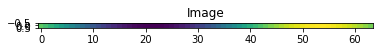

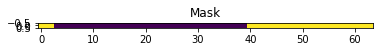

In [4]:
plt.imshow(np.transpose(images[0]))
plt.title('Image')
plt.show()

plt.imshow(np.transpose(masks[0][:,1, np.newaxis]))
plt.title('Mask')
plt.show()

Create DatasetIndex and Dataset to use them in pipeline

In [5]:
ind = DatasetIndex(np.arange(SIZE))            # index for images
dset = Dataset(ind, batch_class=ImagesBatch)
dset.cv_split([0.9, 0.1])                      # divide it into train and test

Define template to load data to batch

In [6]:
load_template = Pipeline().load(src=(images, masks), components=('images', 'masks'))

Create descriptions of inputs

In [7]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, 1),
                                  'type': 'float32',
                                  'data_format': 'channels_last'},
                
                       'masks': {'shape': (IMAGE_SIZE, 2),
                                 'type': 'int32',
                                 'data_format': 'channels_last',
                                 'name': 'targets'}
                       }

Create model_config.
* '<b>inputs</b>' - dict of placeholders configs
* '<b>input_block/inputs</b>' - name of tensor which is an input of input block
* '<b>batch_norm</b>' - enable batch normalization
* '<b>n_blocks</b>' - number of encoding/decoding blocks (4 by default)
* '<b>n_filters</b>' - number of filters after the first convolution (64 by default)
* '<b>output</b>' - dict of operations to add into graph
* '<b>loss</b>' - loss function
* '<b>optimizer</b>' - loss function

In [8]:
model_config = {'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'batch_norm': True,
                'n_blocks': 3,
                'n_filters': 128,
                'output': {'ops': 'proba'},
                'loss': 'softmax_cross_entropy',
                'optimizer': 'Adam'}

In [9]:
train_feed_dict = {'images': B('images'),
                   'masks': B('masks')}        

test_feed_dict = {'images': B('images'),
                  'masks': B('masks')}

Define train and test pipeline

In [10]:
ppl_train = ((load_template << dset.train)
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        LinkNet,                                           # TFModel subclass with LinkNet
                        'linknet',                                         # model name
                        config=model_config)
            .train_model('linknet',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,
                         save_to=[V('train_loss_history')], mode='a'))     # name of pipeline variable to save loss value

ppl_test = ((load_template << dset.test)
            .import_model('linknet', ppl_train)
            .init_variable('predictions', init_on_each_run=list)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet', 
                           fetches=['predicted_proba', 'loss'],
                           feed_dict=test_feed_dict,
                           save_to=[V('predictions'), V('test_loss_history')], mode='a'))

Train the model

In [11]:
start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)                 # training step
    batch = ppl_test.next_batch(100, n_epochs=None)                 # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]   # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]      # get current iteration test loss
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Train time: 0.185 min


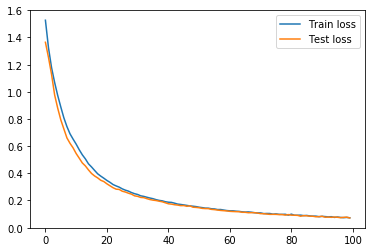

In [12]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_test.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

Plot one prediction

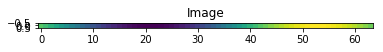

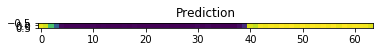

In [13]:
plt.imshow(np.transpose(batch.data.images[0]))
plt.title('Image')
plt.show()
plt.imshow(np.transpose(ppl_test.get_variable('predictions')[-1][0][:,1,np.newaxis]))
plt.title('Prediction')
plt.show()